In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.signal as signal
import pandas as pd
#import pywt
import os



In [ ]:
# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb

# Scientific packages
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy.signal import butter, filtfilt, firwin, iirnotch
import pywt
from scipy.stats import kurtosis, entropy
from sklearn.metrics import mean_squared_error


ISOMÉTRICO

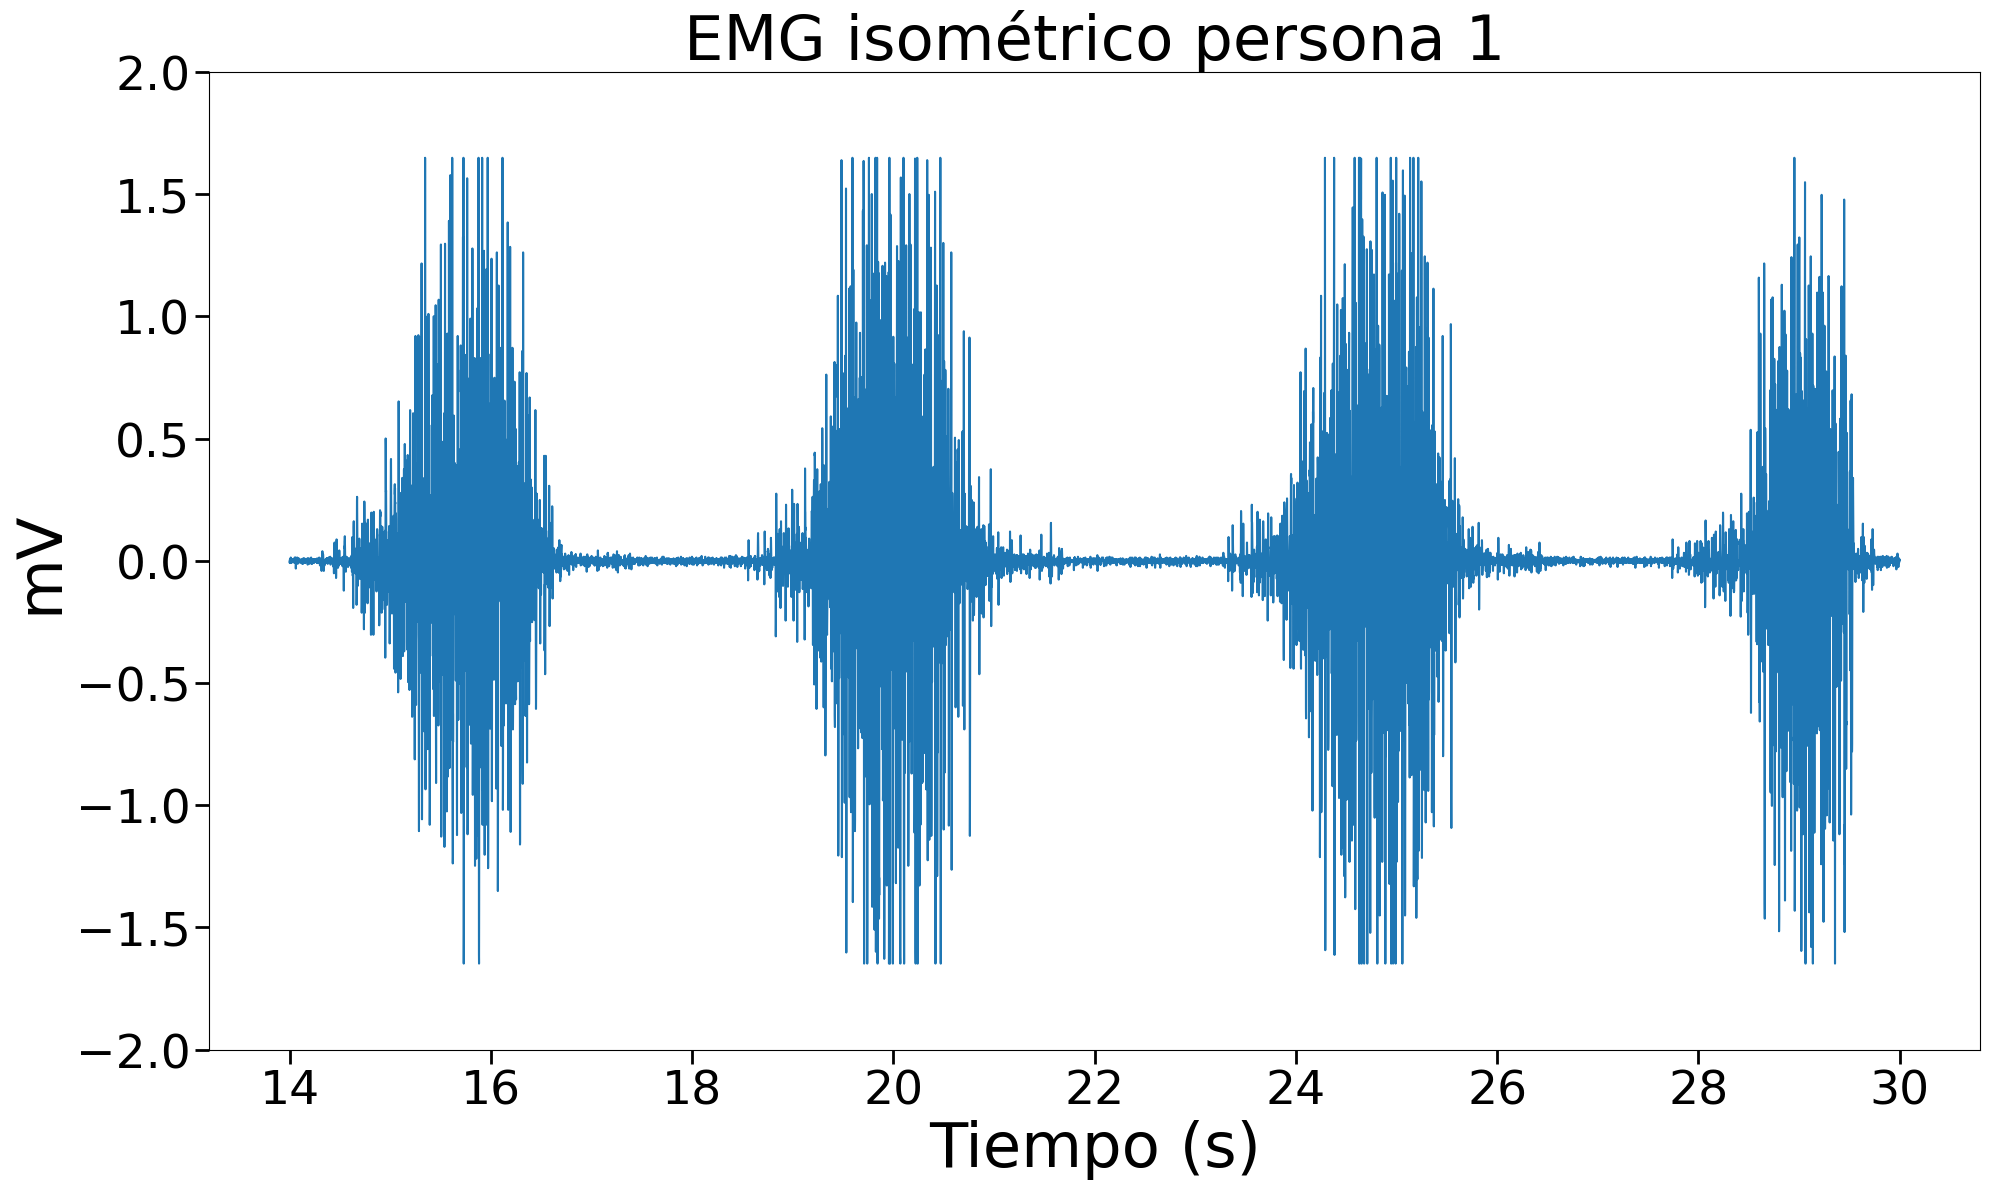

In [66]:
data=np.loadtxt("/content/opensignals_98D3B1FD3DA9_2024-04-12_12-16-36 (1).txt",skiprows=3)

# Convert bits to mV and center the signal
bits = 10  # Bits de la salida
volt_range = 3.3  # Rango de voltaje en milivoltios
data_mV = (data[:, 5] * volt_range / (2**bits - 1))  # Convertir los bits a mV
data_mV_centered = data_mV - np.mean(data_mV)  # Centrar la señal
low_cutoff=14000
high_cutoff=30000

data_mV_centered = data_mV_centered[low_cutoff:high_cutoff]
# Rectify the signal (full-wave rectification)
data_mV_rectified = np.abs(data_mV_centered)

time = np.arange(len(data_mV))/1000
time =time[low_cutoff:high_cutoff]
plt.figure(figsize=(20,12))

plt.plot(time,data_mV_centered)

plt.ylim(-2, 2)
#plt.xlim(0, 31)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('EMG isométrico persona 1', fontsize=45)
plt.tight_layout()


     Average  Standard Deviation   Maximum   Minimum       RMS        Area  \
0   0.121796            0.232105  1.695632  0.000006  0.262120  608.968782   
1   0.190893            0.300613  1.760071  0.000008  0.356102  953.977009   
2   0.187170            0.311072  1.778712  0.000008  0.363041  935.787151   
3   0.156071            0.299613  1.778712  0.000008  0.337826  780.347297   
4   0.155790            0.299746  1.778712  0.000007  0.337814  778.943930   
5   0.159911            0.298807  1.778712  0.000007  0.338906  799.522816   
6   0.177161            0.317924  1.843354  0.000007  0.363953  885.568501   
7   0.156146            0.297475  1.843354  0.000007  0.335966  780.727565   
8   0.154996            0.297948  1.843354  0.000007  0.335852  774.971244   
9   0.155494            0.297733  1.843354  0.000007  0.335891  777.459379   
10  0.188131            0.317672  1.843354  0.000007  0.369200  940.338941   
11  0.143467            0.274446  1.742460  0.000007  0.309682  

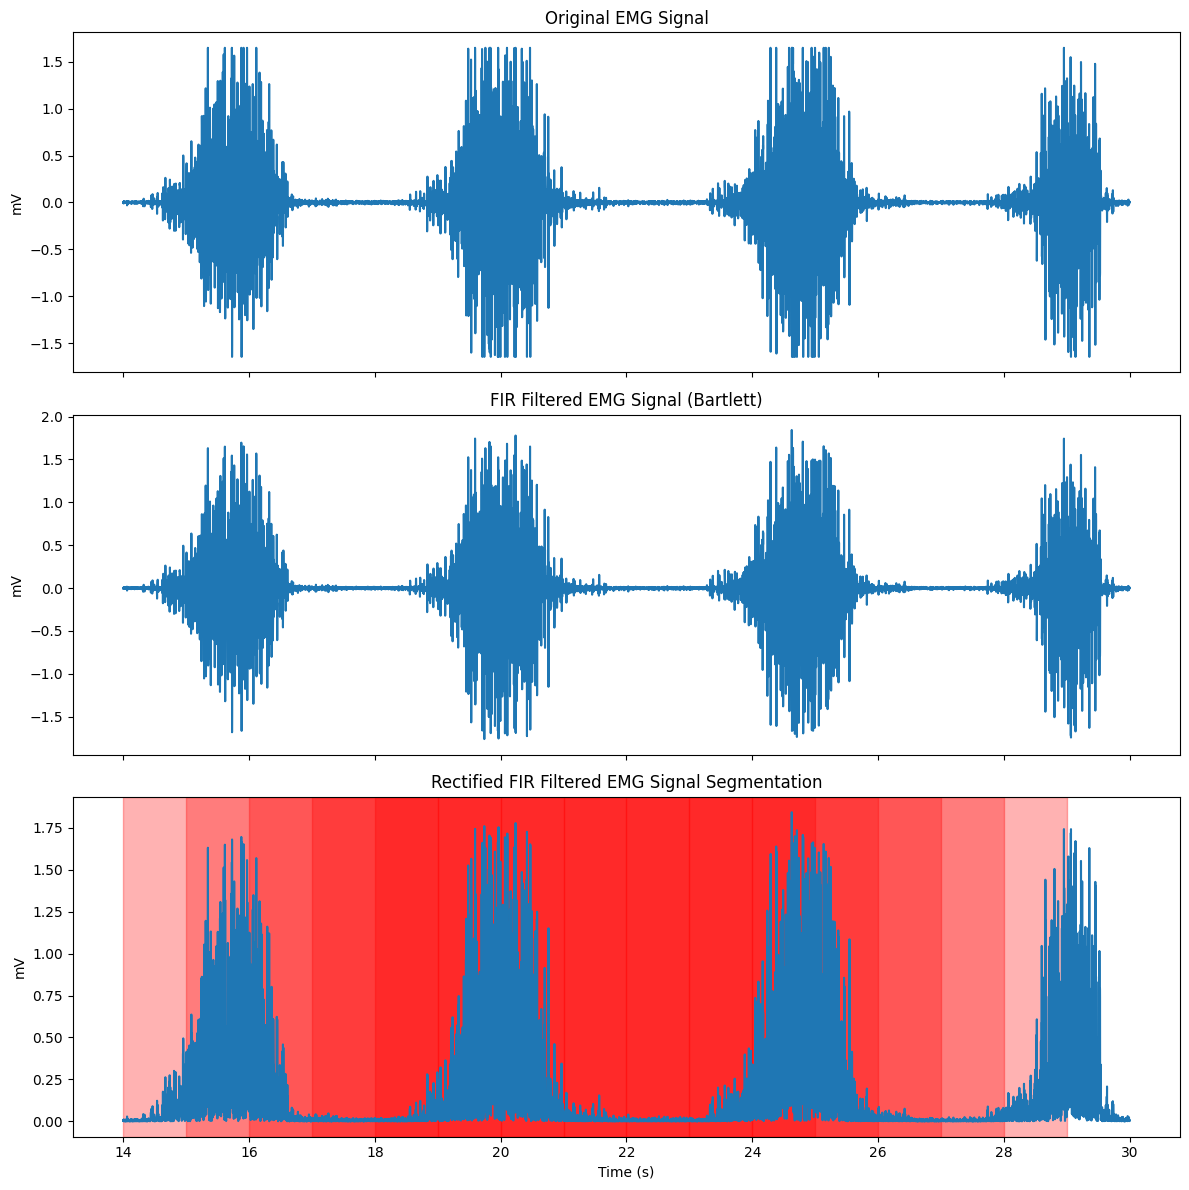

In [67]:
# FIR filter design
def bartlett_fir(data, cutoff, fs, order=20):
    coeff = firwin(order + 1, cutoff / (fs / 2), window='bartlett')
    filtered_data = filtfilt(coeff, 1.0, data)
    return filtered_data

# Apply FIR filter
filtered_fir_bartlett = bartlett_fir(data_mV_centered, cutoff=400, fs=1000, order=20)
filtered_fir_bartlett_rectified = np.abs(filtered_fir_bartlett)

# Segment the EMG signal
def segment_signal(signal, segment_length, increment, sampling_rate):
    segment_samples = int(segment_length * sampling_rate / 1000)
    increment_samples = int(increment * sampling_rate / 1000)
    segments = []
    for start in range(0, len(signal) - segment_samples + 1, increment_samples):
        end = start + segment_samples
        segments.append(signal[start:end])
    return np.array(segments), segment_samples, increment_samples, np.arange(0, len(signal) - segment_samples + 1, increment_samples)

# Segment parameters
segment_length = 5000
increment = 1000
sampling_rate = 1000

# Segment the rectified filtered signal
segments, segment_samples, increment_samples, segment_starts = segment_signal(filtered_fir_bartlett_rectified, segment_length, increment, sampling_rate)

# Additional feature extraction functions
def calculate_kurtosis(signal):
    return kurtosis(signal)

def calculate_entropy(signal):
    return entropy(np.histogram(signal, bins='fd')[0])

def calculate_snr(original_segment, filtered_segment):
    noise = original_segment - filtered_segment
    signal_power = np.mean(original_segment ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float('inf')

# Feature extraction function
def extract_features(segment, sampling_rate, original_signal, segment_start, segment_length):
    max_sample_value = np.max(segment)
    min_sample_value = np.min(segment)
    avg_sample_value = np.mean(segment)
    std_sample_value = np.std(segment)
    rms = np.sqrt(np.mean(segment ** 2))
    area = np.trapz(segment)
    f, P = welch(segment, fs=sampling_rate, window='hanning', noverlap=0, nfft=int(256.))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq >= total_power / 2)[0][0]]
    f_max = f[np.argmax(P)]
    kurt = calculate_kurtosis(segment)
    ent = calculate_entropy(segment)
    original_segment = original_signal[segment_start:segment_start + segment_length]
    snr = calculate_snr(original_segment, segment)
    return [avg_sample_value, std_sample_value, max_sample_value, min_sample_value, rms, area, total_power, median_freq, f_max, kurt, ent, snr]

# Extract features from each segment
features = []
for i, segment in enumerate(segments):
    segment_start = segment_starts[i]
    features.append(extract_features(segment, sampling_rate, data_mV_centered, segment_start, segment_samples))

features_df = pd.DataFrame(features, columns=['Average', 'Standard Deviation', 'Maximum', 'Minimum', 'RMS', 'Area', 'Total Power', 'Median Frequency', 'Max Frequency', 'Kurtosis', 'Entropy', 'SNR'])
print(features_df)

# Plot the original, filtered, and segmented signals with features
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 2, 2]}) # Changed the number of height ratios to 3

# Plot original EMG signal
axs[0].plot(time, data_mV_centered)
axs[0].set_ylabel('mV')
axs[0].set_title('Original EMG Signal')

# Plot FIR filtered EMG signal
axs[1].plot(time, filtered_fir_bartlett)
axs[1].set_ylabel('mV')
axs[1].set_title('FIR Filtered EMG Signal (Bartlett)')

# Plot rectified FIR filtered EMG signal with segmentation
axs[2].plot(time, filtered_fir_bartlett_rectified)
axs[2].set_ylabel('mV')
axs[2].set_title('Rectified FIR Filtered EMG Signal Segmentation')
axs[2].set_xlabel('Time (s)')


for start in segment_starts:
    end = start + segment_samples
    if end < len(time):
        axs[2].axvspan(time[start], time[end], color='red', alpha=0.3)

plt.tight_layout()
plt.show()

In [68]:
import numpy as np
import pandas as pd
import os

# Directorio de destino para los archivos CSV
directorio_destino = './isometrico1'

# Crear el directorio si aún no existe
if not os.path.exists(directorio_destino):
    os.makedirs(directorio_destino)

# Iterar sobre cada segmento y guardarlos como archivos CSV numerados
for indice, segmento in enumerate(segments):
    # Crear un DataFrame con marcas de tiempo y datos del canal
    datos = pd.DataFrame({
        'timestamp': np.arange(1, len(segmento) + 1),
        'señal': segmento
    })

    # Ruta del archivo CSV con numeración secuencial
    archivo_csv = os.path.join(directorio_destino, f'isometrico{indice + 1}.csv')

    # Guardar el DataFrame como archivo CSV
    datos.to_csv(archivo_csv, index=False)

CONTRAFUERZA

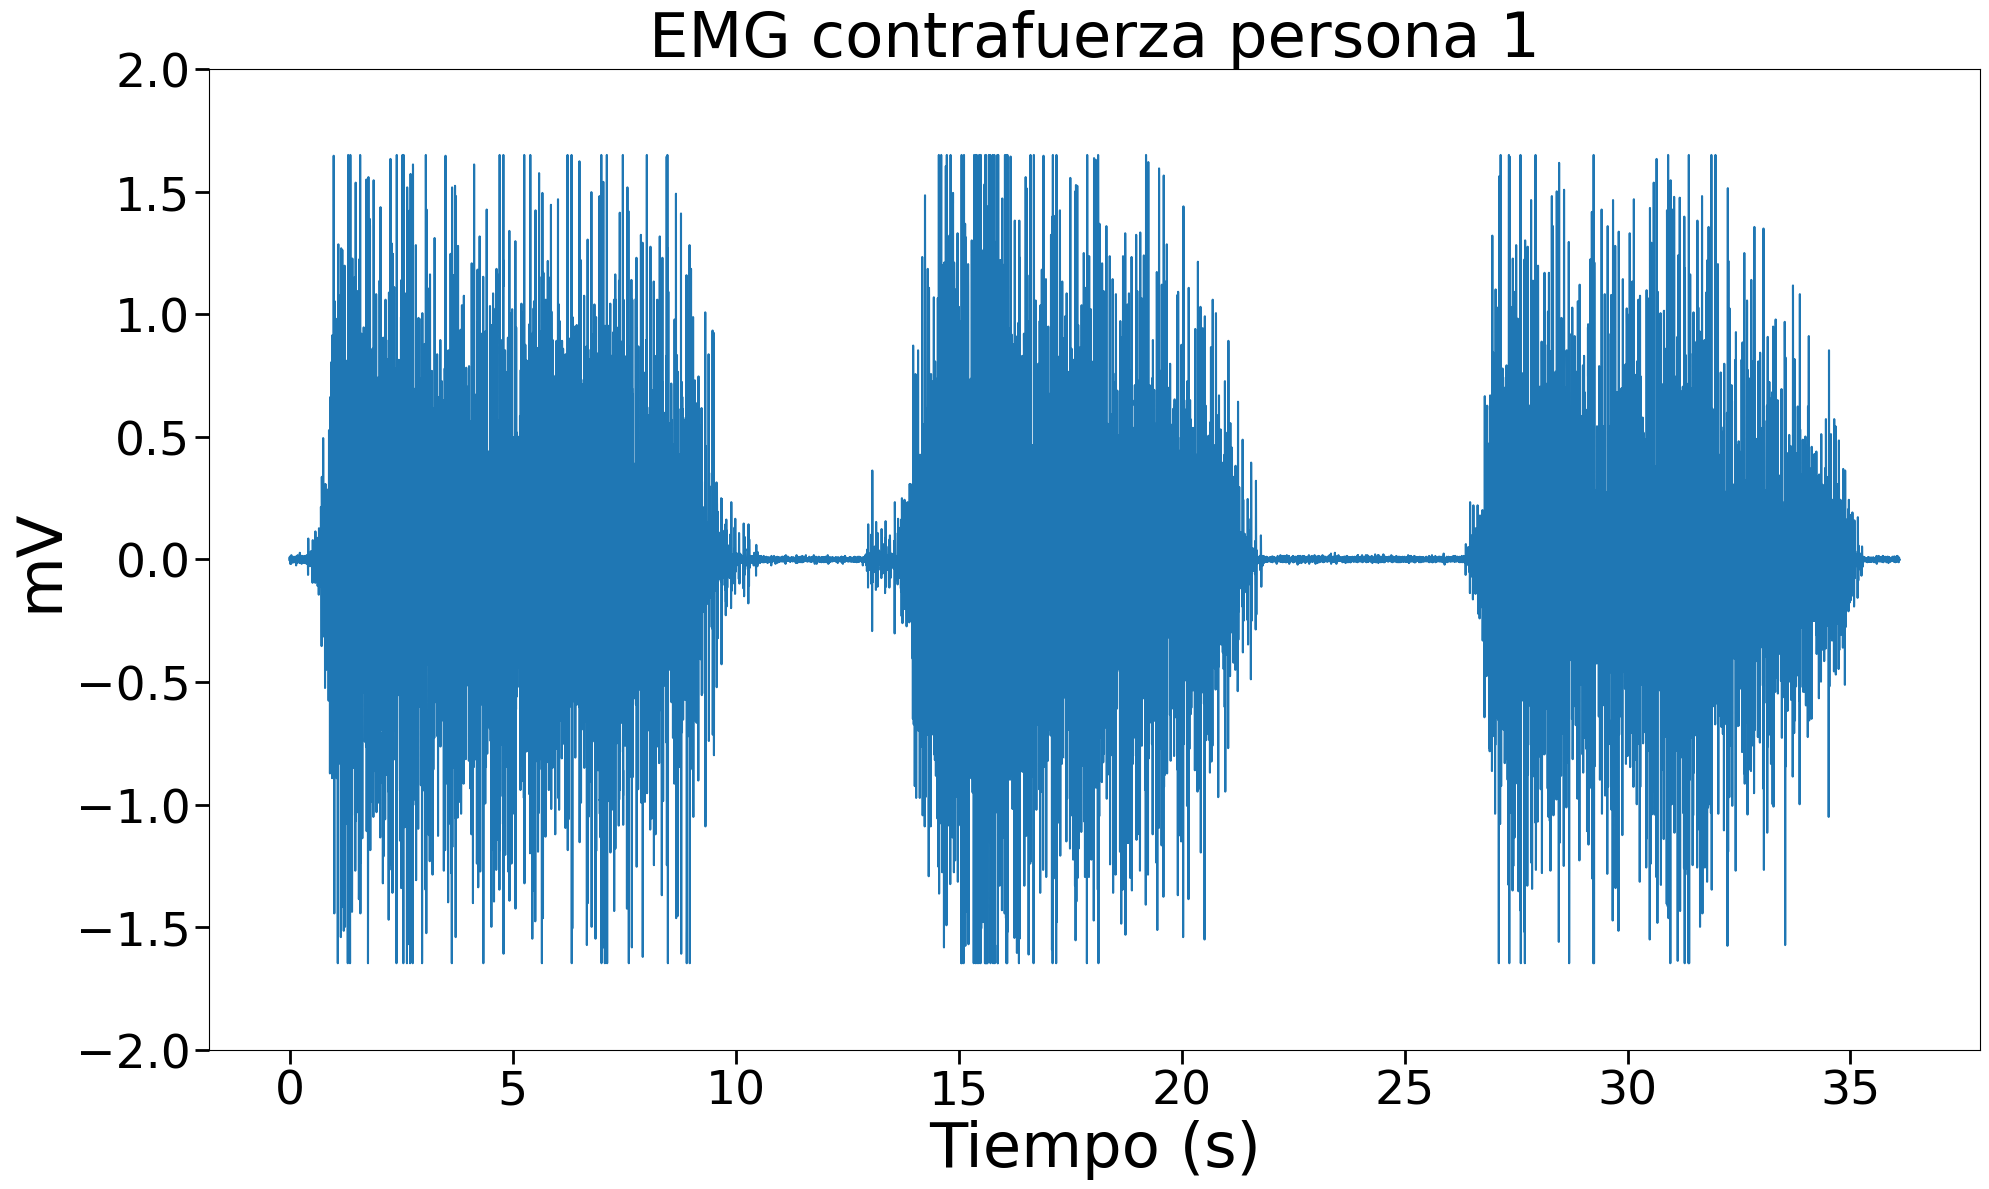

In [63]:
data=np.loadtxt("/content/opensignals_98D3B1FD3DA9_2024-04-12_12-19-52.txt",skiprows=3)

bits = 10 # Bits de la salida
volt_range = 3.3 #Rango de voltaje en milivoltios
data_mV = (data[:,5] * volt_range/(2**bits - 1)) # convertir los bits a mV
data_mV_centered = data_mV - np.mean(data_mV)  # Centrar la señal
low_cutoff=14000
high_cutoff=50100

data_mV_centered = data_mV_centered[low_cutoff:high_cutoff]

# Rectify the signal (full-wave rectification)
data_mV_rectified = np.abs(data_mV_centered)

# Adjust the time array to match the sliced data
time = np.arange(len(data_mV_centered))/1000

plt.figure(figsize=(20,12))

plt.plot(time,data_mV_centered)

plt.ylim(-2, 2)
#plt.xlim(13, 31)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('EMG contrafuerza persona 1', fontsize=45)
plt.tight_layout()

#Tomamos solo 5 segundos de la señal
y_1=data_mV[15000:20000]

Fs = 1000
Ts=1/Fs # Determinar el periodo de muestreo
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo

     Average  Standard Deviation   Maximum       Minimum       RMS  \
0   0.399076            0.376029  1.794039  1.514232e-05  0.548324   
1   0.457747            0.366700  1.794039  5.519487e-05  0.586516   
2   0.421739            0.349877  1.794039  5.519487e-05  0.547976   
3   0.394062            0.336681  1.768186  5.519487e-05  0.518304   
4   0.382757            0.337858  1.768186  5.519487e-05  0.510540   
5   0.330512            0.328026  1.768186  6.431213e-05  0.465660   
6   0.255447            0.314917  1.768186  2.503345e-05  0.405494   
7   0.179878            0.284680  1.768186  1.258624e-07  0.336747   
8   0.102809            0.218523  1.661985  1.258624e-07  0.241500   
9   0.045365            0.112296  1.084774  1.258624e-07  0.121113   
10  0.110610            0.253215  1.689598  1.258624e-07  0.276319   
11  0.247003            0.396824  1.736404  1.258624e-07  0.467418   
12  0.352100            0.427976  1.770316  2.597054e-06  0.554200   
13  0.451476        

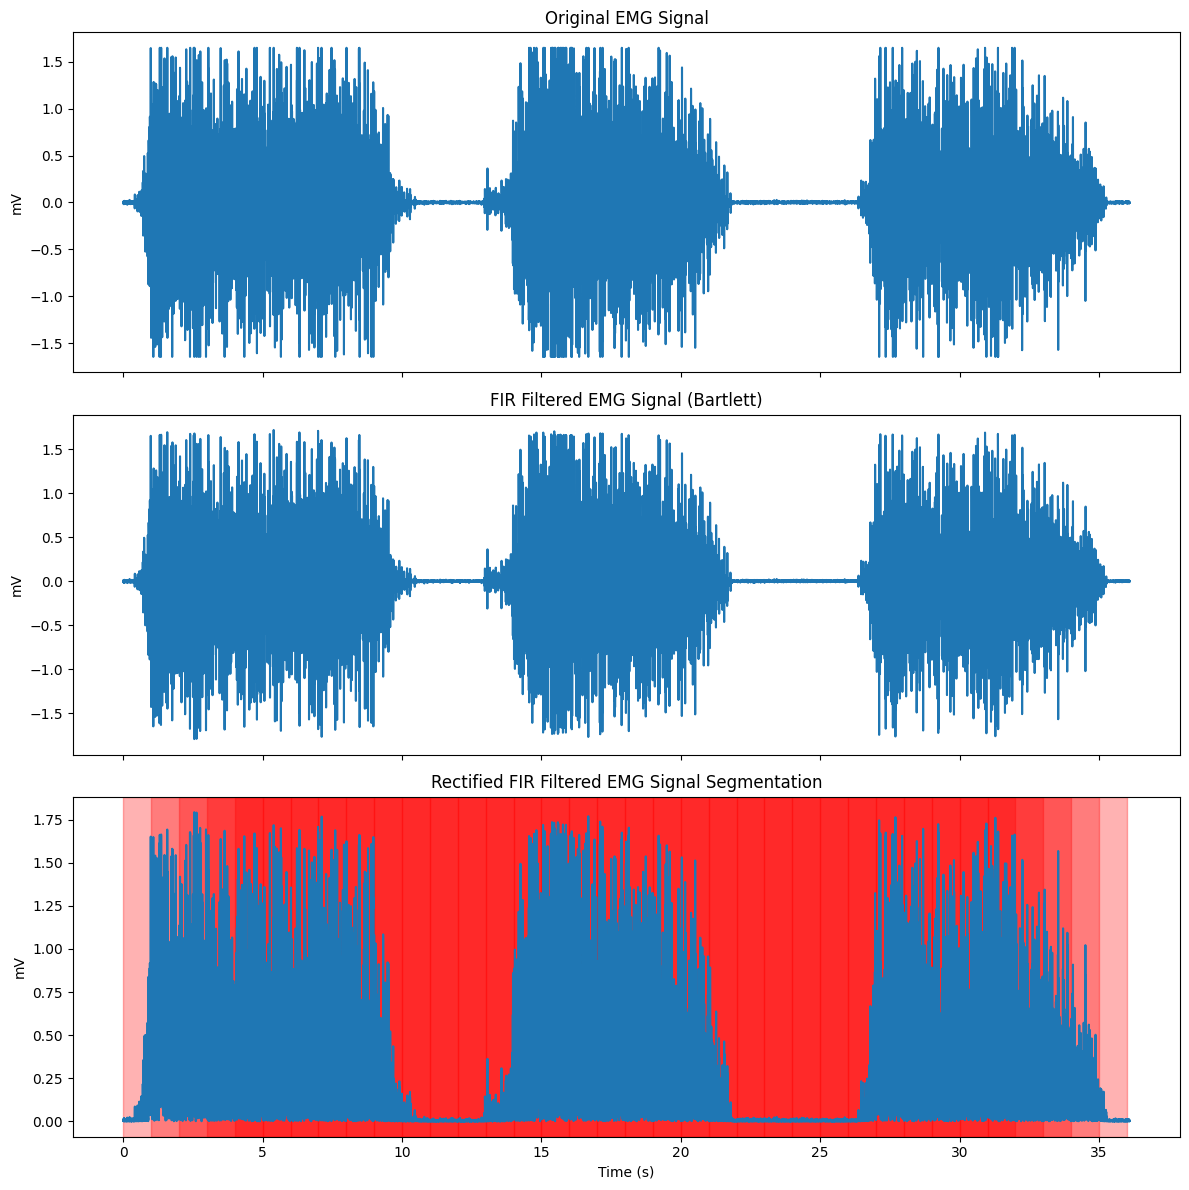

In [64]:
# FIR filter design
def bartlett_fir(data, cutoff, fs, order=20):
    coeff = firwin(order + 1, cutoff / (fs / 2), window='bartlett')
    filtered_data = filtfilt(coeff, 1.0, data)
    return filtered_data

# Apply FIR filter
filtered_fir_bartlett = bartlett_fir(data_mV_centered, cutoff=400, fs=1000, order=20)
filtered_fir_bartlett_rectified = np.abs(filtered_fir_bartlett)

# Segment the EMG signal
def segment_signal(signal, segment_length, increment, sampling_rate):
    segment_samples = int(segment_length * sampling_rate / 1000)
    increment_samples = int(increment * sampling_rate / 1000)
    segments = []
    for start in range(0, len(signal) - segment_samples + 1, increment_samples):
        end = start + segment_samples
        segments.append(signal[start:end])
    return np.array(segments), segment_samples, increment_samples, np.arange(0, len(signal) - segment_samples + 1, increment_samples)

# Segment parameters
segment_length = 5000
increment = 1000
sampling_rate = 1000

# Segment the rectified filtered signal
segments, segment_samples, increment_samples, segment_starts = segment_signal(filtered_fir_bartlett_rectified, segment_length, increment, sampling_rate)

# Additional feature extraction functions
def calculate_kurtosis(signal):
    return kurtosis(signal)

def calculate_entropy(signal):
    return entropy(np.histogram(signal, bins='fd')[0])

def calculate_snr(original_segment, filtered_segment):
    noise = original_segment - filtered_segment
    signal_power = np.mean(original_segment ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float('inf')

# Feature extraction function
def extract_features(segment, sampling_rate, original_signal, segment_start, segment_length):
    max_sample_value = np.max(segment)
    min_sample_value = np.min(segment)
    avg_sample_value = np.mean(segment)
    std_sample_value = np.std(segment)
    rms = np.sqrt(np.mean(segment ** 2))
    area = np.trapz(segment)
    f, P = welch(segment, fs=sampling_rate, window='hanning', noverlap=0, nfft=int(256.))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq >= total_power / 2)[0][0]]
    f_max = f[np.argmax(P)]
    kurt = calculate_kurtosis(segment)
    ent = calculate_entropy(segment)
    original_segment = original_signal[segment_start:segment_start + segment_length]
    snr = calculate_snr(original_segment, segment)
    return [avg_sample_value, std_sample_value, max_sample_value, min_sample_value, rms, area, total_power, median_freq, f_max, kurt, ent, snr]

# Extract features from each segment
features = []
for i, segment in enumerate(segments):
    segment_start = segment_starts[i]
    features.append(extract_features(segment, sampling_rate, data_mV_centered, segment_start, segment_samples))

features_df = pd.DataFrame(features, columns=['Average', 'Standard Deviation', 'Maximum', 'Minimum', 'RMS', 'Area', 'Total Power', 'Median Frequency', 'Max Frequency', 'Kurtosis', 'Entropy', 'SNR'])
print(features_df)

# Plot the original, filtered, and segmented signals with features
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 2, 2]})

# Plot original EMG signal
axs[0].plot(time, data_mV_centered)
axs[0].set_ylabel('mV')
axs[0].set_title('Original EMG Signal')

# Plot FIR filtered EMG signal
axs[1].plot(time, filtered_fir_bartlett)
axs[1].set_ylabel('mV')
axs[1].set_title('FIR Filtered EMG Signal (Bartlett)')

# Plot rectified FIR filtered EMG signal with segmentation
axs[2].plot(time, filtered_fir_bartlett_rectified)
axs[2].set_ylabel('mV')
axs[2].set_title('Rectified FIR Filtered EMG Signal Segmentation')
for start in segment_starts:
    end = start + segment_samples
    if end < len(time):
        axs[2].axvspan(time[start], time[end], color='red', alpha=0.3)

axs[2].set_xlabel('Time (s)')

plt.tight_layout()

plt.show()

In [65]:
# Directorio de destino para los archivos CSV
directorio_destino = './contrafuerza1'

# Crear el directorio si aún no existe
if not os.path.exists(directorio_destino):
    os.makedirs(directorio_destino)

# Iterar sobre cada segmento y guardarlos como archivos CSV numerados
for indice, segmento in enumerate(segments):
    # Crear un DataFrame con marcas de tiempo y datos del canal
    datos = pd.DataFrame({
        'timestamp': np.arange(1, len(segmento) + 1),
        'señal': segmento
    })

    # Ruta del archivo CSV con numeración secuencial
    archivo_csv = os.path.join(directorio_destino, f'contrafuerza{indice + 1}.csv')

    # Guardar el DataFrame como archivo CSV
    datos.to_csv(archivo_csv, index=False)